In [1]:
#importing all the dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
## Display all the columns of the dataframe

pd.pandas.set_option('display.max_columns',None)


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import make_scorer,log_loss

import keras 
from keras.layers import Dense,Dropout,Activation
from keras.models import Sequential
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

Using TensorFlow backend.


In [2]:
#reading the training dataset
data=pd.read_csv(r'C:\Users\KIIT_Intern\Desktop\Machinehack\ODI_Participants_Data\Train.csv',
                 error_bad_lines=False)
data.shape

(2508, 10)

In [3]:
data.head()

,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner
0,5,4,37,4,Home,Away,Second,First,Dec,4
1,1,14,84,7,Neutral,Neutral,First,Second,Sep,1
2,9,15,47,9,Home,Away,First,Second,Feb,9
3,7,2,102,6,Home,Away,First,Second,Aug,2
4,6,8,46,5,Home,Away,First,Second,Aug,6


In [4]:
data.columns

Index(['Team1', 'Team2', 'Stadium', 'HostCountry', 'Team1_Venue',
       'Team2_Venue', 'Team1_Innings', 'Team2_Innings', 'MonthOfMatch',
       'MatchWinner'],
      dtype='object')

In [5]:
#make a copy of the dataset
dataset=data.copy()

In [6]:
#let's find what is the percentage of missing values in the dataset
features_null=[features for features in dataset.columns if dataset[features].isnull().sum()>1]

for feature in features_null:
    print(feature, np.round(dataset[feature].isnull().mean()*100, 4), '% missing values')

So we can see there is no missing values in the dataset.So let's go ahead with EDA.

In [7]:
dataset.dtypes

Team1             int64
Team2             int64
Stadium           int64
HostCountry       int64
Team1_Venue      object
Team2_Venue      object
Team1_Innings    object
Team2_Innings    object
MonthOfMatch     object
MatchWinner       int64
dtype: object

# EDA

# Temporal variable

Temporal variables are those variables which are datetime variables.

As we can see there is no temporal variable, only one feature is there which is called monthofmatch 
which is a categorical feature which we will handle later.

# Numerical variable

In [9]:
# list of numerical variables
numerical_var = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_var))

# visualise the numerical variables
dataset[numerical_var].head()

Number of numerical variables:  5


,Team1,Team2,Stadium,HostCountry,MatchWinner
0,5,4,37,4,4
1,1,14,84,7,1
2,9,15,47,9,9
3,7,2,102,6,2
4,6,8,46,5,6


So these are my numerical features, but as I understand from the dataset, these values are encoded and they are actually categorical features or ordinal variables to be precise which are already encoded.

These columns can also be treated as discrete numerical variables.

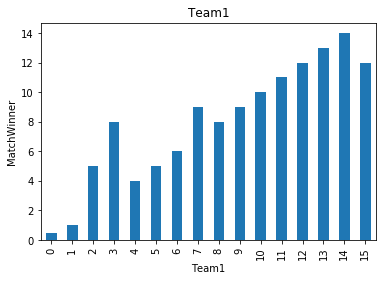

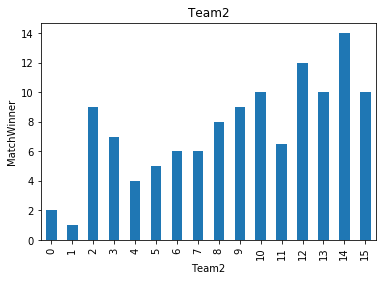

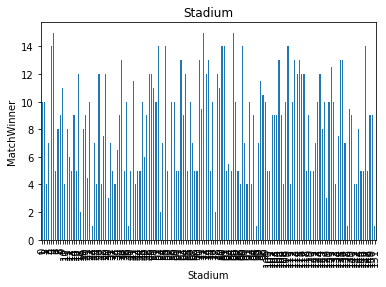

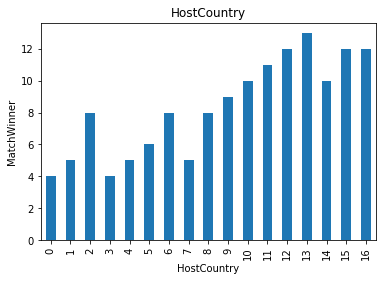

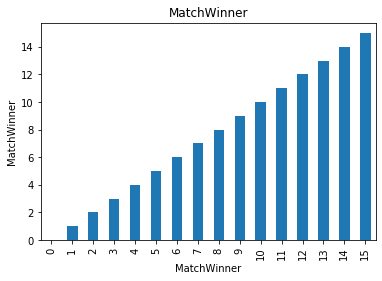

In [11]:
## Lets Find the realtionship between them and our target variable.
for feature in numerical_var:
    data=dataset.copy()
    data.groupby(feature)['MatchWinner'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('MatchWinner')
    plt.title(feature)
    plt.show()

# Categorical variable( unencoded )

In [12]:
categorical_features=[feature for feature in dataset.columns if data[feature].dtypes=='O']
categorical_features

['Team1_Venue',
 'Team2_Venue',
 'Team1_Innings',
 'Team2_Innings',
 'MonthOfMatch']

In [13]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,
                                                                     len(dataset[feature].unique())))

The feature is Team1_Venue and number of categories are 3
The feature is Team2_Venue and number of categories are 3
The feature is Team1_Innings and number of categories are 2
The feature is Team2_Innings and number of categories are 2
The feature is MonthOfMatch and number of categories are 12


So these are the number of categories in our categorical features.

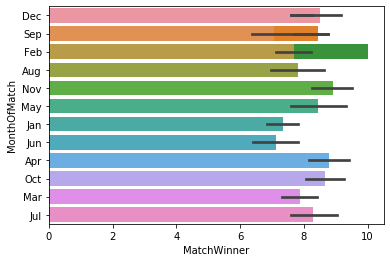

In [15]:
for feature in categorical_features:
    data=dataset.copy()
    sns.barplot(x=data['MatchWinner'],y=feature,data=data,)

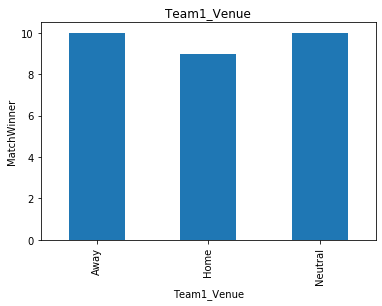

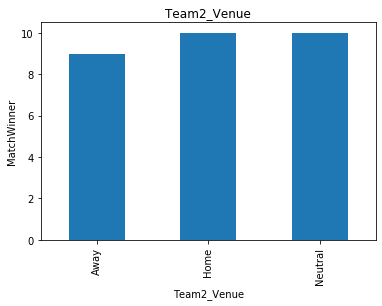

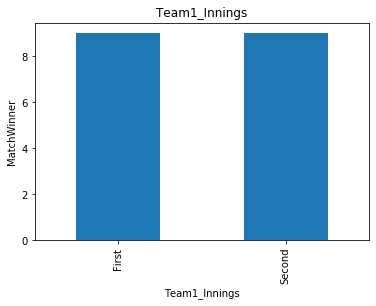

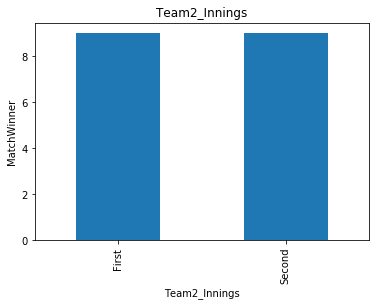

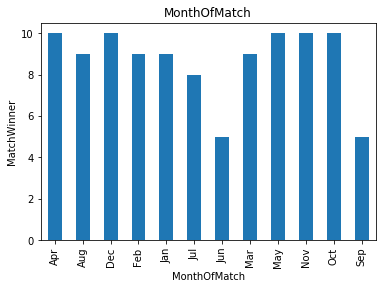

In [17]:
for feature in categorical_features:
    data=dataset.copy()
    data.groupby(feature)['MatchWinner'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('MatchWinner')
    plt.title(feature)
    plt.show()

As our target variable is not a continuous numerical variable, we can not clearly derive relation between the target variable and other features.

Now, let's go to the feature engineering part.

# Feature engineering

Handling the categorical columns

In [19]:
print(categorical_features)

['Team1_Venue', 'Team2_Venue', 'Team1_Innings', 'Team2_Innings', 'MonthOfMatch']


In [20]:
#monthofmatch
dataset['MonthOfMatch']=dataset['MonthOfMatch'].astype('category')
dataset['month_of_match_cat']=dataset['MonthOfMatch'].cat.codes   #labelencoding

In [21]:
#team1Innings 
dataset['team1_innings']=np.where(dataset['Team1_Innings']=='First',1,0) #onehotencoding

In [22]:
#Team venues
dataset=pd.get_dummies(dataset, columns=['Team1_Venue','Team2_Venue'],drop_first=True)

In [23]:
dataset.head()

,Team1,Team2,Stadium,HostCountry,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner,month_of_match_cat,team1_innings,Team1_Venue_Home,Team1_Venue_Neutral,Team2_Venue_Home,Team2_Venue_Neutral
0,5,4,37,4,Second,First,Dec,4,2,0,1,0,0,0
1,1,14,84,7,First,Second,Sep,1,11,1,0,1,0,1
2,9,15,47,9,First,Second,Feb,9,3,1,1,0,0,0
3,7,2,102,6,First,Second,Aug,2,1,1,1,0,0,0
4,6,8,46,5,First,Second,Aug,6,1,1,1,0,0,0


In [24]:
#dropping unnecessary columns
dataset.drop(['Team1_Innings','Team2_Innings','MonthOfMatch'],
             inplace=True, axis=1)

In [25]:
dataset.shape

(2508, 11)

So we don't have any categorical columns now, each and every column is encoded and ready to be used in the model

# Feature selection

As the number of features are very much small and the data is also small, so I decided to use all the features and build the model.

# Model 

In [26]:
#first we have to split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(labels=['MatchWinner'], axis=1),
    dataset['MatchWinner'],
    test_size=0.25,
    random_state=0)

X_train.shape, X_test.shape

((1881, 10), (627, 10))

RandomForest with gridsearchCV

In [ ]:
rf_estimator = RandomForestClassifier(random_state=45)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rf_estimator, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
rfc_model=RandomForestClassifier(random_state=45, 
                            max_features='auto',
                            n_estimators= 500,
                            max_depth=8, 
                            criterion='entropy')

rfc_model.fit(X_train, y_train)

In [ ]:
predsprob = rfc_model.predict_proba(X_test)
log_loss(y_test,predsprob)

I didn't get good score with this , so I used another approach

XGBoost with gridsearchCV

In [ ]:
xgb_estimator = xgb.XGBClassifier()

In [ ]:
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

In [ ]:
CV_xgb = GridSearchCV(xgb_estimator,param_grid, n_jobs=5, 
                   cv=5, 
                   scoring='accuracy',
                   verbose=2, refit=True)
CV_xgb.fit(X_train, y_train)

In [ ]:
CV_xgb.best_params_

In [ ]:
xgb_model=xgb.XGBClassifier(colsample_bytree=0.8,
                        max_depth=15,
                        n_estimators=700,
                        reg_alpha=1.3,
                        reg_lambda=1.1,
                        subsample=0.7)
xgb_model.fit(X_train,y_train)

In [ ]:
predsprob = xgb_model.predict_proba(X_test)
log_loss(y_test,predsprob)

I got a logloss value of 1.0045 in this case which is better than randomforest, I tried to explore more of this

I checked for Pearson correlation between the features to remove the correlated features

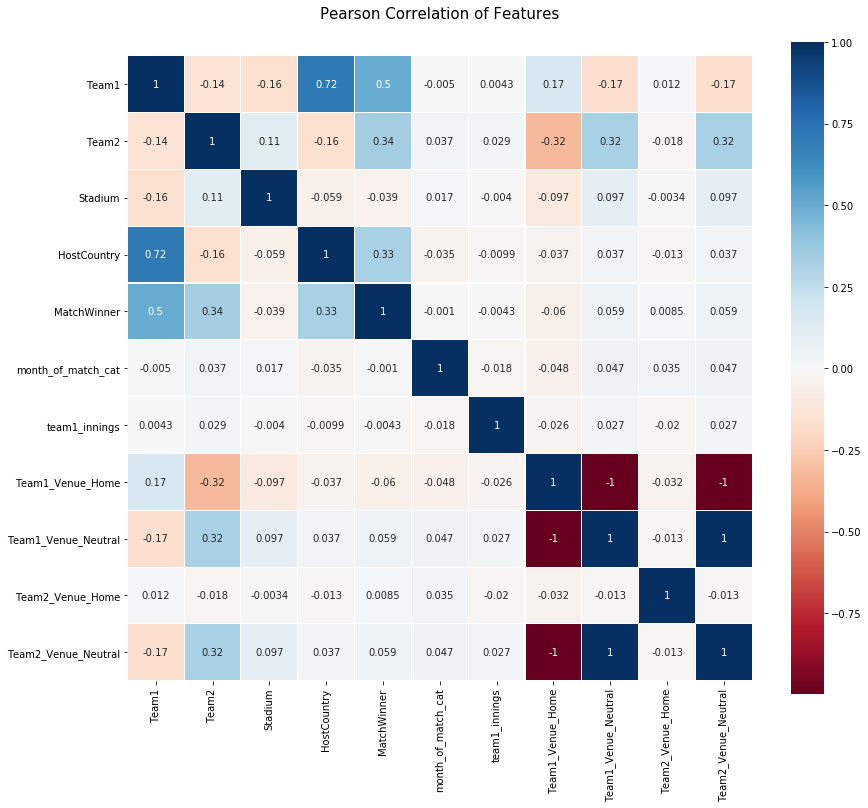

In [27]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(dataset.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [28]:
# I dropped the following feature from my train and test set
X_train.drop('Team1_Venue_Neutral',inplace=True, axis=1)
X_test.drop('Team1_Venue_Neutral',inplace=True, axis=1)

LightGBM with gridserchCV

In [ ]:
lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt', 
                                   num_boost_round=2000, 
                                   learning_rate=0.01)

In [ ]:
param_grid = {
    'num_leaves': [31, 127,55],
    'reg_alpha': [0.1, 0.5, 0.2],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5, 2],
    'lambda_l2': [0, 1, 1.5]
    }

In [ ]:
CV_lgb = GridSearchCV(estimator=lgb_estimator,
                       param_grid=param_grid, 
                       cv=5)
CV_lgb.fit(X_train,y_train)

In [ ]:
CV_lgb.best_params_

In [ ]:
lgb_model=lgb.LGBMClassifier(lambda_l1=1.5,
                             lambda_l2=1,
                             min_data_in_leaf=50,
                             num_leaves=31,
                             reg_alpha=0.1)
lgb_model.fit(X_train,y_train)

In [ ]:
predsprob=lgb_model.predict_proba(X_test)

In [ ]:
log_loss(y_test,predsprob)

I got a reduced logloss value of 0.734260923221914, which is best so far.

.

.

This is a basic notebook with boosting and ensemble ML algorithms. The data was so small and clean, it'll be challenging to work with messy and un structured data. We can also apply NN here , though I haven't used it. 